In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import azureml.core
from azureml.core import Workspace

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.26.0


In [3]:
# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, sep='\t')

If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.


webinar-ml-workspace	westeurope	webinar-dryrun-code


In [4]:
from azureml.core import Experiment
experiment_name = 'Tutorial-sklearn-mnist'

exp = Experiment(workspace=ws, name=experiment_name)

In [5]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
import os

# choose a name for your cluster
compute_name = os.environ.get("AML_COMPUTE_CLUSTER_NAME", "cpu-cluster-1279")
compute_min_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MIN_NODES", 0)
compute_max_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MAX_NODES", 2)

# This example uses CPU VM. For using GPU VM, set SKU to STANDARD_NC6
vm_size = os.environ.get("AML_COMPUTE_CLUSTER_SKU", "STANDARD_D2_V2")


if compute_name in ws.compute_targets:
    compute_target = ws.compute_targets[compute_name]
    if compute_target and type(compute_target) is AmlCompute:
        print('found compute target. just use it. ' + compute_name)
else:
    print('creating a new compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size=vm_size,
                                                                min_nodes=compute_min_nodes,
                                                                max_nodes=compute_max_nodes)

    # create the cluster
    compute_target = ComputeTarget.create(
        ws, compute_name, provisioning_config)

    # can poll for a minimum number of nodes and for a specific timeout.
    # if no min node count is provided it will use the scale settings for the cluster
    compute_target.wait_for_completion(
        show_output=True, min_node_count=None, timeout_in_minutes=20)

    # For a more detailed view of current AmlCompute status, use get_status()
    print(compute_target.get_status().serialize())

found compute target. just use it. cpu-cluster-1279


In [6]:
from azureml.core import Dataset
from azureml.opendatasets import MNIST

data_folder = os.path.join(os.getcwd(), 'data')
os.makedirs(data_folder, exist_ok=True)

mnist_file_dataset = MNIST.get_file_dataset()
mnist_file_dataset.download(data_folder, overwrite=True)

mnist_file_dataset = mnist_file_dataset.register(workspace=ws,
                                                 name='mnist_opendataset',
                                                 description='training and test dataset',
                                                 create_new_version=True)

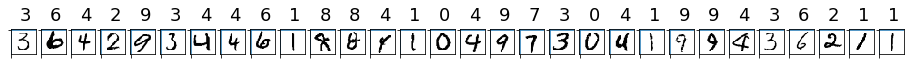

In [8]:
# make sure utils.py is in the same directory as this code
from utils import load_data
import glob


# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the model converge faster.
X_train = load_data(glob.glob(os.path.join(data_folder,"**/train-images-idx3-ubyte.gz"), recursive=True)[0], False) / 255.0
X_test = load_data(glob.glob(os.path.join(data_folder,"**/t10k-images-idx3-ubyte.gz"), recursive=True)[0], False) / 255.0
y_train = load_data(glob.glob(os.path.join(data_folder,"**/train-labels-idx1-ubyte.gz"), recursive=True)[0], True).reshape(-1)
y_test = load_data(glob.glob(os.path.join(data_folder,"**/t10k-labels-idx1-ubyte.gz"), recursive=True)[0], True).reshape(-1)


# now let's show some randomly chosen images from the traininng set.
count = 0
sample_size = 30
plt.figure(figsize=(16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x=10, y=-10, s=y_train[i], fontsize=18)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.Greys)
plt.show()

In [9]:
import os
script_folder = os.path.join(os.getcwd(), "sklearn-mnist")
os.makedirs(script_folder, exist_ok=True)

In [10]:
%%writefile $script_folder/train.py

import argparse
import os
import numpy as np
import glob

from sklearn.linear_model import LogisticRegression
import joblib

from azureml.core import Run
from utils import load_data

# let user feed in 2 parameters, the dataset to mount or download, and the regularization rate of the logistic regression model
parser = argparse.ArgumentParser()
parser.add_argument('--data-folder', type=str, dest='data_folder', help='data folder mounting point')
parser.add_argument('--regularization', type=float, dest='reg', default=0.01, help='regularization rate')
args = parser.parse_args()

data_folder = args.data_folder
print('Data folder:', data_folder)

# load train and test set into numpy arrays
# note we scale the pixel intensity values to 0-1 (by dividing it with 255.0) so the model can converge faster.
X_train = load_data(glob.glob(os.path.join(data_folder, '**/train-images-idx3-ubyte.gz'), recursive=True)[0], False) / 255.0
X_test = load_data(glob.glob(os.path.join(data_folder, '**/t10k-images-idx3-ubyte.gz'), recursive=True)[0], False) / 255.0
y_train = load_data(glob.glob(os.path.join(data_folder, '**/train-labels-idx1-ubyte.gz'), recursive=True)[0], True).reshape(-1)
y_test = load_data(glob.glob(os.path.join(data_folder, '**/t10k-labels-idx1-ubyte.gz'), recursive=True)[0], True).reshape(-1)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, sep = '\n')

# get hold of the current run
run = Run.get_context()

print('Train a logistic regression model with regularization rate of', args.reg)
clf = LogisticRegression(C=1.0/args.reg, solver="liblinear", multi_class="auto", random_state=42)
clf.fit(X_train, y_train)

print('Predict the test set')
y_hat = clf.predict(X_test)

# calculate accuracy on the prediction
acc = np.average(y_hat == y_test)
print('Accuracy is', acc)

run.log('regularization rate', np.float(args.reg))
run.log('accuracy', np.float(acc))

os.makedirs('outputs', exist_ok=True)
# note file saved in the outputs folder is automatically uploaded into experiment record
joblib.dump(value=clf, filename='outputs/sklearn_mnist_model.pkl')

Writing C:\Users\user\Desktop\Azure_ML_Session\Demos\Demo2\sklearn-mnist/train.py


In [11]:
import shutil
shutil.copy('utils.py', script_folder)

'C:\\Users\\user\\Desktop\\Azure_ML_Session\\Demos\\Demo2\\sklearn-mnist\\utils.py'

In [12]:
from azureml.core.environment import Environment
from azureml.core.conda_dependencies import CondaDependencies

# to install required packages
env = Environment('tutorial-env')
cd = CondaDependencies.create(pip_packages=['azureml-dataset-runtime[pandas,fuse]', 'azureml-defaults'], conda_packages=['scikit-learn==0.22.1'])

env.python.conda_dependencies = cd

# Register environment to re-use later
env.register(workspace=ws)

{
    "databricks": {
        "eggLibraries": [],
        "jarLibraries": [],
        "mavenLibraries": [],
        "pypiLibraries": [],
        "rcranLibraries": []
    },
    "docker": {
        "arguments": [],
        "baseDockerfile": null,
        "baseImage": "mcr.microsoft.com/azureml/intelmpi2018.3-ubuntu16.04:20210301.v1",
        "baseImageRegistry": {
            "address": null,
            "password": null,
            "registryIdentity": null,
            "username": null
        },
        "enabled": false,
        "platform": {
            "architecture": "amd64",
            "os": "Linux"
        },
        "sharedVolumes": true,
        "shmSize": null
    },
    "environmentVariables": {
        "EXAMPLE_ENV_VAR": "EXAMPLE_VALUE"
    },
    "inferencingStackVersion": null,
    "name": "tutorial-env",
    "python": {
        "baseCondaEnvironment": null,
        "condaDependencies": {
            "channels": [
                "anaconda",
                "conda-forge"

In [13]:
from azureml.core import ScriptRunConfig

args = ['--data-folder', mnist_file_dataset.as_mount(), '--regularization', 0.5]

src = ScriptRunConfig(source_directory=script_folder,
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [14]:
run = exp.submit(config=src)

In [15]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

In [16]:
run.wait_for_completion(show_output=True)  # specify True for a verbose log

RunId: Tutorial-sklearn-mnist_1618063110_dc7af648
Web View: https://ml.azure.com/runs/Tutorial-sklearn-mnist_1618063110_dc7af648?wsid=/subscriptions/627b39d5-583d-4275-89b8-b43f00ec12c5/resourcegroups/webinar-dryrun-code/workspaces/webinar-ml-workspace&tid=c5eef0ea-2adf-445f-8104-084ab26b162b

Streaming azureml-logs/20_image_build_log.txt

2021/04/10 13:58:40 Downloading source code...
2021/04/10 13:58:42 Finished downloading source code
2021/04/10 13:58:42 Creating Docker network: acb_default_network, driver: 'bridge'
2021/04/10 13:58:42 Successfully set up Docker network: acb_default_network
2021/04/10 13:58:42 Setting up Docker configuration...
2021/04/10 13:58:43 Successfully set up Docker configuration
2021/04/10 13:58:43 Logging in to registry: 13348feafa3a44cab363e96d4e016b23.azurecr.io
2021/04/10 13:58:44 Successfully logged into 13348feafa3a44cab363e96d4e016b23.azurecr.io
2021/04/10 13:58:44 Executing step ID: acb_step_0. Timeout(sec): 5400, Working directory: '', Network: 'ac


done
#
# To activate this environment, use
#
#     $ conda activate /azureml-envs/azureml_dd931c128d406a7bbcd016af032c59ce
#
# To deactivate an active environment, use
#
#     $ conda deactivate



==> WARNING: A newer version of conda exists. <==
  current version: 4.9.2
  latest version: 4.10.0

Please update conda by running

    $ conda update -n base -c defaults conda


Removing intermediate container fd072b2ffd55
 ---> 469100f1f5b4
Step 9/18 : ENV PATH /azureml-envs/azureml_dd931c128d406a7bbcd016af032c59ce/bin:$PATH
 ---> Running in c12fb0ae860a
Removing intermediate container c12fb0ae860a
 ---> da7a043bb23e
Step 10/18 : COPY azureml-environment-setup/send_conda_dependencies.py azureml-environment-setup/send_conda_dependencies.py
 ---> 770f41a25e6c
Step 11/18 : COPY azureml-environment-setup/environment_context.json azureml-environment-setup/environment_context.json
 ---> 1def052932d8
Step 12/18 : RUN python /azureml-environment-setup/send_conda_dependencies.py -p /azureml-envs/


Streaming azureml-logs/55_azureml-execution-tvmps_bd9ffe1767a3f0e69be34ad89cbb11d9c21d54e73f659a205e43dcd0e46f9c17_d.txt

2021-04-10T14:08:16Z Successfully mounted a/an Blobfuse File System at /mnt/batch/tasks/shared/LS_root/jobs/webinar-ml-workspace/azureml/tutorial-sklearn-mnist_1618063110_dc7af648/mounts/workspaceblobstore
2021-04-10T14:08:17Z Starting output-watcher...
2021-04-10T14:08:17Z IsDedicatedCompute == True, won't poll for Low Pri Preemption
2021-04-10T14:08:18Z Executing 'Copy ACR Details file' on 10.0.0.4
2021-04-10T14:08:18Z Copy ACR Details file succeeded on 10.0.0.4. Output: 
>>>   
>>>   
Login Succeeded
Using default tag: latest
latest: Pulling from azureml/azureml_75dbdd65efabd34ac9f6ccab5f74b4b0
4007a89234b4: Pulling fs layer
5dfa26c6b9c9: Pulling fs layer
0ba7bf18aa40: Pulling fs layer
4c6ec688ebe3: Pulling fs layer
574f361512d6: Pulling fs layer
db4d1e2d7079: Pulling fs layer
e544ee0f522d: Pulling fs layer
c655136086be: Pulling fs layer
2ec37f44090c: Pulling fs


Streaming azureml-logs/75_job_post-tvmps_bd9ffe1767a3f0e69be34ad89cbb11d9c21d54e73f659a205e43dcd0e46f9c17_d.txt

[2021-04-10T14:11:41.857577] Entering job release
[2021-04-10T14:11:43.213605] Starting job release
[2021-04-10T14:11:43.214139] Logging experiment finalizing status in history service.[2021-04-10T14:11:43.214793] job release stage : upload_datastore starting...[2021-04-10T14:11:43.214967] job release stage : start importing azureml.history._tracking in run_history_release.
[2021-04-10T14:11:43.215020] job release stage : execute_job_release starting...

Starting the daemon thread to refresh tokens in background for process with pid = 339

[2021-04-10T14:11:43.215829] job release stage : copy_batchai_cached_logs starting...
[2021-04-10T14:11:43.218290] job release stage : copy_batchai_cached_logs completed...
[2021-04-10T14:11:43.286457] Entering context manager injector.
[2021-04-10T14:11:43.370131] job release stage : upload_datastore completed...
[2021-04-10T14:11:43.404

{'runId': 'Tutorial-sklearn-mnist_1618063110_dc7af648',
 'target': 'cpu-cluster-1279',
 'status': 'Completed',
 'startTimeUtc': '2021-04-10T14:08:18.417015Z',
 'endTimeUtc': '2021-04-10T14:11:56.061921Z',
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': '688f5ff6-5404-472f-811f-43d1db558ab9',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': 'f67715dd-1a29-4db3-a101-f283c9abc30a'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'input__f67715dd', 'mechanism': 'Mount'}}],
 'outputDatasets': [],
 'runDefinition': {'script': 'train.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': ['--data-folder',
   'DatasetConsumptionConfig:input__f67715dd',
   '--regularization',
   '0.5'],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'cpu-cluster-1279',
  'dataReferences': {},
  'data': {'

In [17]:
print(run.get_metrics())

{'regularization rate': 0.5, 'accuracy': 0.9193}


In [18]:
print(run.get_file_names())

['azureml-logs/20_image_build_log.txt', 'azureml-logs/55_azureml-execution-tvmps_bd9ffe1767a3f0e69be34ad89cbb11d9c21d54e73f659a205e43dcd0e46f9c17_d.txt', 'azureml-logs/65_job_prep-tvmps_bd9ffe1767a3f0e69be34ad89cbb11d9c21d54e73f659a205e43dcd0e46f9c17_d.txt', 'azureml-logs/70_driver_log.txt', 'azureml-logs/75_job_post-tvmps_bd9ffe1767a3f0e69be34ad89cbb11d9c21d54e73f659a205e43dcd0e46f9c17_d.txt', 'azureml-logs/process_info.json', 'azureml-logs/process_status.json', 'logs/azureml/77_azureml.log', 'logs/azureml/dataprep/backgroundProcess.log', 'logs/azureml/dataprep/backgroundProcess_Telemetry.log', 'logs/azureml/job_prep_azureml.log', 'logs/azureml/job_release_azureml.log', 'logs/azureml/sidecar/tvmps_bd9ffe1767a3f0e69be34ad89cbb11d9c21d54e73f659a205e43dcd0e46f9c17_d/all.log', 'logs/azureml/sidecar/tvmps_bd9ffe1767a3f0e69be34ad89cbb11d9c21d54e73f659a205e43dcd0e46f9c17_d/task.enter_contexts.log', 'logs/azureml/sidecar/tvmps_bd9ffe1767a3f0e69be34ad89cbb11d9c21d54e73f659a205e43dcd0e46f9c17_d

In [19]:
# register model
model = run.register_model(model_name='sklearn_mnist',
                           model_path='outputs/sklearn_mnist_model.pkl')
print(model.name, model.id, model.version, sep='\t')

sklearn_mnist	sklearn_mnist:1	1


In [ ]:
# Optionally, delete the Azure Machine Learning Compute cluster
compute_target.delete()